In [1]:
### Python port from R codes for the article: Khoury, D.S., Cromer, D., Reynaldi, A. et al. Neutralizing antibody levels are highly predictive of immune protection from symptomatic SARS-CoV-2 infection. Nat Med 27, 1205–1211 (2021). https://doi.org/10.1038/s41591-021-01377-8

import pandas as pd
import numpy as np
import scipy
import scipy.stats
import scipy.stats as stats
import numdifftools as nd
from scipy import optimize
import scipy.optimize as opt
from scipy.stats import norm
from scipy.stats import binom
from pprint import pprint

In [2]:
### Import Tables For fitting Models
### For threshold and logistic
SummaryTable_Efficacy_NeutRatio_SD_SEM = pd.read_csv("python_SummaryTable_Efficacy_NeutRatio_SD_SEM.csv")
SummaryTable_Efficacy_NeutRatio_SD_SEM['LogRate_Inf'] = np.log(
    SummaryTable_Efficacy_NeutRatio_SD_SEM['InfCont'] / SummaryTable_Efficacy_NeutRatio_SD_SEM['NumCont']
)

SummaryTable_Efficacy_NeutRatio_SD_SEM['RatioReported_LB']= np.power(10, ((SummaryTable_Efficacy_NeutRatio_SD_SEM['NeutRatio_Reported'])-1.96*SummaryTable_Efficacy_NeutRatio_SD_SEM['SEM']))
SummaryTable_Efficacy_NeutRatio_SD_SEM['RatioReported_UB']= np.power(10, ((SummaryTable_Efficacy_NeutRatio_SD_SEM['NeutRatio_Reported'])+1.96*SummaryTable_Efficacy_NeutRatio_SD_SEM['SEM']))

SummaryTable_Efficacy_NeutRatio_SD_SEM

,Unnamed: 0,Study,Age,Efficacy,NumCont,NumVac,InfCont,InfVac,DayNeut,NeutMean,...,NumberIndividuals_Vaccine,SD_Conv,SD_Vaccine,SEM,PooledSD,MelbSD,NeutRatio_Reported,LogRate_Inf,RatioReported_LB,RatioReported_UB
0,0,Pfizer,all,0.9503,18325,18198,162,8,28,223.0000,...,24.0,0.389783,0.379668,0.100022,0.439127,0.474093,0.375177,-4.728425,1.510548,3.725800
1,1,Moderna,all,0.9408,14073,14134,185,11,43,654.3000,...,14.0,0.334182,0.206426,0.200673,0.439127,0.474093,0.616296,-4.331658,1.671005,10.223846
2,2,Sputnik,all,0.9155,4902,14964,62,16,42,49.2500,...,20.0,0.653066,0.357453,0.124350,0.439127,0.474093,0.148338,-4.370264,0.802808,2.466408
3,3,Novavac,all,0.9566,7495,7505,23,1,35,3906.0000,...,20.0,0.626048,0.523904,0.157867,0.439127,0.474093,0.599179,-5.786497,1.948766,8.102103
4,4,JJ,all,0.6734,18603,18604,300,98,29,245.5000,...,54.0,0.593364,0.435201,0.120457,0.439127,0.474093,-0.327619,-4.127296,0.273077,0.809985
5,5,Astra,all,0.6184,4455,4440,71,27,42,32.0000,...,9.0,0.236166,0.244085,0.133322,0.439127,0.474093,-0.265702,-4.139102,0.297158,0.989938
6,6,CoronaVac,all,0.5040,6416,6584,167,85,56,27.6000,...,41.0,0.583655,0.492288,0.095059,0.439127,0.474093,-0.773140,-3.648556,0.109786,0.258926
7,7,Convalescence,all,0.8900,11276,1177,197,2,28,55.7943,...,64.0,0.474093,0.474093,0.083809,0.439127,0.474093,0.000000,-4.047228,0.685070,1.459704


In [11]:
##########################################################################################
##################### The Models

####Logistic Model
def ProbRemainUninfected(logTitre, logk, C50):
  return (1 / (1 + np.exp(-np.exp(logk) * (logTitre - C50))))

def LogisticModel_PercentUninfected(mu_titre, sig_titre, logk, C50):

  #
  mu_titre = [mu_titre]
  sig_titre = [sig_titre]
  #

  Output = []

  if (np.size(C50)==1):
    C50=np.repeat(C50,np.size(mu_titre))

  if (np.size(logk)==1):
    logk=np.repeat(logk,np.size(mu_titre))

  for i in range(np.size(mu_titre)):
    Step=sig_titre[i]*0.001
    IntegralVector=np.arange(
      mu_titre[i]-5*sig_titre[i],
      (mu_titre[i]+5*sig_titre[i]) + Step,
      step=Step
    )
    
    Output.insert(i, np.sum(ProbRemainUninfected(IntegralVector,logk[i],C50[i])*norm.pdf(IntegralVector,mu_titre[i],sig_titre[i]))*Step)

    

  return Output[0]

### Logistic model for Raw Efficacy Counts
def dbinom(x,size,prob):
  return binom.pmf(k=x,n=size,p=prob,loc=0)

def FittingLogistic_Raw(logRisk0, logk, C50, N_C, N_V, Inf_C, Inf_V, MeanVector, SDVector):

  Risk0 = np.exp(logRisk0)

  if (np.size(SDVector)==1):
    SDVector=np.repeat(SDVector,np.size(N_C))

  if (np.size(C50)==1):
    C50=np.repeat(C50,np.size(N_C))

  if (np.size(logk)==1):
    logk=np.repeat(logk,np.size(N_C))
    
  LL = 0

  for i in range(np.size(N_C)):
    LL = LL -np.log(dbinom(Inf_C[i],N_C[i],Risk0[i])) - np.log(dbinom(Inf_V[i],N_V[i],Risk0[i]*(1-LogisticModel_PercentUninfected(MeanVector[i],SDVector[i],logk[i],C50[i]))))

  return LL
  
##########################################################################################
##Fitting Models
# Initial values
LogisticEstimate = {
    'logk' : np.log(2.7),
    'C50'  : np.log10(0.5),
    'logRisk0' : SummaryTable_Efficacy_NeutRatio_SD_SEM.loc[SummaryTable_Efficacy_NeutRatio_SD_SEM['Study'] == 'Convalescence', 'LogRate_Inf'].iat[0]
}

def plfit(x0):
    return FittingLogistic_Raw(
        x0[:-2],
        x0[-2],
        x0[-1],
        SummaryTable_Efficacy_NeutRatio_SD_SEM['NumCont'].to_numpy(),
        SummaryTable_Efficacy_NeutRatio_SD_SEM['NumVac'].to_numpy(),
        SummaryTable_Efficacy_NeutRatio_SD_SEM['InfCont'].to_numpy(),
        SummaryTable_Efficacy_NeutRatio_SD_SEM['InfVac'].to_numpy(),
        SummaryTable_Efficacy_NeutRatio_SD_SEM['NeutRatio_Reported'].to_numpy(),
        SummaryTable_Efficacy_NeutRatio_SD_SEM['PooledSD'].to_numpy())


x0 = np.append(SummaryTable_Efficacy_NeutRatio_SD_SEM['LogRate_Inf'].to_numpy(), [LogisticEstimate['logk'], LogisticEstimate['C50']])

FittedLogistic_RawEfficacy_MeanRept_SDPool = opt.minimize(
  plfit, x0,
  method='BFGS',
  options={'disp': True}
  )

FittedLogistic_RawEfficacy_MeanRept_SDPool_estimates = FittedLogistic_RawEfficacy_MeanRept_SDPool.x
pprint(FittedLogistic_RawEfficacy_MeanRept_SDPool_estimates)

<ipython-input-11-6bc072f8d4bf>:57: RuntimeWarning: divide by zero encountered in log
  LL = LL -np.log(dbinom(Inf_C[i],N_C[i],Risk0[i])) - np.log(dbinom(Inf_V[i],N_V[i],Risk0[i]*(1-LogisticModel_PercentUninfected(MeanVector[i],SDVector[i],logk[i],C50[i]))))
/home/albertdo/.local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
<ipython-input-11-6bc072f8d4bf>:57: RuntimeWarning: divide by zero encountered in log
  LL = LL -np.log(dbinom(Inf_C[i],N_C[i],Risk0[i])) - np.log(dbinom(Inf_V[i],N_V[i],Risk0[i]*(1-LogisticModel_PercentUninfected(MeanVector[i],SDVector[i],logk[i],C50[i]))))


Optimization terminated successfully.
         Current function value: 48.033563
         Iterations: 17
         Function evaluations: 289
         Gradient evaluations: 26
array([-4.74957185, -4.31294463, -4.4576234 , -5.78438017, -4.10978175,
       -4.05906542, -3.68049361, -4.05434856,  1.09896874, -0.6944858 ])


In [12]:
###### Display inverse Hessian matrix
FittedLogistic_RawEfficacy_MeanRept_SDPool.hess_inv

array([[ 6.08691510e-03,  1.59902747e-04,  4.76802026e-04,
         2.59030802e-04,  2.94400388e-05,  1.11634373e-04,
        -1.48611099e-04,  1.28884554e-05,  2.08745270e-03,
         6.86916797e-04],
       [ 1.59902747e-04,  5.14815439e-03,  4.63888481e-04,
         2.32033204e-04,  8.62864809e-05,  1.76949019e-04,
        -1.06048991e-04,  1.74315416e-05,  1.72688949e-03,
         6.30828539e-04],
       [ 4.76802026e-04,  4.63888481e-04,  1.34762862e-02,
         5.13117156e-04, -2.07378142e-04, -7.42027152e-05,
        -3.39162911e-04, -1.30737010e-04,  4.13316657e-03,
         5.34641477e-04],
       [ 2.59030802e-04,  2.32033204e-04,  5.13117156e-04,
         4.20102443e-02, -2.21239713e-04,  1.43079297e-07,
        -3.32042952e-04, -2.52813306e-04,  2.90381938e-03,
         1.16754602e-03],
       [ 2.94400388e-05,  8.62864809e-05, -2.07378142e-04,
        -2.21239713e-04,  2.40383372e-03, -2.02337085e-05,
         2.80132066e-04, -1.48846475e-04, -1.25644971e-03,
        -1.

In [4]:
###### Manuscript Figures
NeutValue = np.arange(0.1,11+0.001,step=0.001)

Efficacy_Logistic = []
Efficacy_Logistic_Raw = []

for i in range(np.size(NeutValue)):
  Efficacy_Logistic_Raw.insert(i, 
    LogisticModel_PercentUninfected(
      np.log10(NeutValue[i]),
      SummaryTable_Efficacy_NeutRatio_SD_SEM['PooledSD'].iat[0],
      FittedLogistic_RawEfficacy_MeanRept_SDPool_estimates[-2],
      FittedLogistic_RawEfficacy_MeanRept_SDPool_estimates[-1]) )
 
LogisticModel_withPoolSD = pd.DataFrame(
  {
    'NeutRatio_Reported': np.log10(NeutValue),
    'Efficacy': Efficacy_Logistic_Raw,
    'Study': np.repeat("LogisticModel", np.size(NeutValue))
  }
)  

#### Adding 95% Prediction Intervals ####
Cov = FittedLogistic_RawEfficacy_MeanRept_SDPool.hess_inv[-2:,-2:]

Lower_Pred, Upper_Pred = [], []

for i in range(np.size(NeutValue)):
    f_temp = lambda p_temp: LogisticModel_PercentUninfected(np.log10(NeutValue[i]), SummaryTable_Efficacy_NeutRatio_SD_SEM['PooledSD'].iat[0], p_temp[0], p_temp[1])
    d = nd.Gradient(f_temp)([FittedLogistic_RawEfficacy_MeanRept_SDPool_estimates[-2], FittedLogistic_RawEfficacy_MeanRept_SDPool_estimates[-1]])
    G = np.array([d[0], d[1]])
    Lower_Pred.insert(i, Efficacy_Logistic_Raw[i]-1.96*np.sqrt(G @ Cov @ G.T))
    Upper_Pred.insert(i, Efficacy_Logistic_Raw[i]+1.96*np.sqrt(G @ Cov @ G.T))

LogisticModel_withPoolSD['Lower'] = np.multiply(100, Lower_Pred)
LogisticModel_withPoolSD['Upper'] = np.multiply(100, Upper_Pred)


In [7]:
LogisticModel_withPoolSD.head()
SummaryTable_Efficacy_NeutRatio_SD_SEM.head()


,Unnamed: 0,Study,Age,Efficacy,NumCont,NumVac,InfCont,InfVac,DayNeut,NeutMean,...,NumberIndividuals_Vaccine,SD_Conv,SD_Vaccine,SEM,PooledSD,MelbSD,NeutRatio_Reported,LogRate_Inf,RatioReported_LB,RatioReported_UB
0,0,Pfizer,all,0.9503,18325,18198,162,8,28,223.00,...,24.0,0.389783,0.379668,0.100022,0.439127,0.474093,0.375177,-4.728425,1.510548,3.725800
1,1,Moderna,all,0.9408,14073,14134,185,11,43,654.30,...,14.0,0.334182,0.206426,0.200673,0.439127,0.474093,0.616296,-4.331658,1.671005,10.223846
2,2,Sputnik,all,0.9155,4902,14964,62,16,42,49.25,...,20.0,0.653066,0.357453,0.124350,0.439127,0.474093,0.148338,-4.370264,0.802808,2.466408
3,3,Novavac,all,0.9566,7495,7505,23,1,35,3906.00,...,20.0,0.626048,0.523904,0.157867,0.439127,0.474093,0.599179,-5.786497,1.948766,8.102103
4,4,JJ,all,0.6734,18603,18604,300,98,29,245.50,...,54.0,0.593364,0.435201,0.120457,0.439127,0.474093,-0.327619,-4.127296,0.273077,0.809985


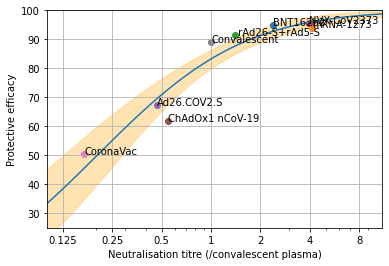

<Figure size 1080x1080 with 0 Axes>

In [17]:
#### Plot ####
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.figure(figsize=(15, 15))
ax.set_xlabel('Neutralisation titre (/convalescent plasma)')
ax.set_ylabel('Protective efficacy')
ax.plot(np.power(10, LogisticModel_withPoolSD['NeutRatio_Reported']), np.multiply(100, LogisticModel_withPoolSD['Efficacy']))
ax.fill_between(
    np.power(10, LogisticModel_withPoolSD['NeutRatio_Reported']),
    LogisticModel_withPoolSD['Lower'],
    LogisticModel_withPoolSD['Upper'],
    color='orange', alpha=0.3
    )

for index, row in SummaryTable_Efficacy_NeutRatio_SD_SEM.iterrows():
    ax.annotate(row['TechnicalName'], (np.power(10, row['NeutRatio_Reported']), np.multiply(100, row['Efficacy'])))
    ax.scatter(x=np.power(10, row['NeutRatio_Reported']) , y=np.multiply(100, row['Efficacy']))


ax.set_xscale('log')
ax.set_xlim(0.1, 11)
ax.set_xticks([0.125,0.25,0.5,1,2,4,8])
ax.set_xticklabels([0.125,0.25,0.5,1,2,4,8])
ax.set_ylim(25, 100)
ax.set_yscale('linear')
ax.grid(True)

plt.show()